# Интеллектуальный анализ данных – весна 2025

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов.


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [412]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [415]:
def count_H(arr):
    return np.sum(-p_i * np.log(p_i))

p_i = np.array([0.8, 0.2])

res_H = round(count_H(p_i), 2)
print(f"Энтропия распределения классов: {res_H}")

Энтропия распределения классов: 0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [418]:
def gini(arr):
    return np.sum(arr * (1 - arr))


L = np.array([1, 0])
R = np.array([0, 1])
R_l = 8
R_r = 2
R_m = 10

Q = gini(p_i) - (R_l / R_m) * gini(L) - (R_r / R_m) * gini(R)

print(Q)

0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [421]:
nums = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
y_avg = round(np.average(nums), 2)

print(f"Предсказанием модели для модели регрессии будет среднее значение, равное: {y_avg}")

Предсказанием модели для модели регрессии будет среднее значение, равное: 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [424]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [427]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух соседних (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    X = np.array(feature_vector)
    y = np.array(target_vector)

    sorted_idx = np.argsort(X)  
    X_sorted = X[sorted_idx]    
    y_sorted = y[sorted_idx]


    thresholds = (X_sorted[1:] + X_sorted[:-1]) / 2
    
    if task == "classification":
        left_cumsum = np.cumsum(y_sorted[:-1])
        left_counts = np.arange(1, len(X_sorted))
        
        p_left = left_cumsum / left_counts
        p_right = (np.sum(y_sorted) - left_cumsum) / (len(y_sorted) - left_counts)
        
        gini_left = gini(p_left)
        gini_right = gini(p_right)
        
        weights_left = left_counts / len(y_sorted)
        weights_right = 1 - weights_left 
        ginis = weights_left * gini_left + weights_right * gini_right

        best_idx = np.argmax(ginis)
        best_threshold = thresholds[best_idx]
        best_gini = ginis[best_idx] 
        
        return thresholds, ginis, best_threshold, best_gini
    
    elif task == "regression":
        left_cumsum = np.cumsum(y_sorted[:-1]) 
        left_cumsum_sq = np.cumsum(y_sorted[:-1]**2)
        left_counts = np.arange(1, len(X_sorted)) 
        
        right_cumsum = np.sum(y_sorted) - left_cumsum  
        right_cumsum_sq = np.sum(y_sorted**2) - left_cumsum_sq  
        right_counts = len(y_sorted) - left_counts  
        
        var_left = left_cumsum_sq / left_counts - (left_cumsum / left_counts)**2 
        var_right = right_cumsum_sq / right_counts - (right_cumsum / right_counts)**2  
        
        weights_left = left_counts / len(y_sorted)
        weights_right = 1 - weights_left
        mse_reduction = np.var(y_sorted) - (weights_left * var_left + weights_right * var_right) 
        
        best_idx = np.argmax(mse_reduction) 
        best_threshold = thresholds[best_idx] 
        best_mse_red = mse_reduction[best_idx] 
        
        return thresholds, mse_reduction, best_threshold, best_mse_red
    
    


Эту функцию можно протестировать на датасете `California`.

In [430]:
from sklearn.datasets import fetch_california_housing

In [432]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]

feature_vector = X['MedInc'].values
target_vector = y

# Запускаем нашу функцию для задачи регрессии
thresholds, criteria, best_threshold, best_criterion = find_best_split(
    feature_vector=feature_vector,
    target_vector=target_vector,
    task="regression",
    feature_type="real"
)

print(f"Лучший порог: {best_threshold:.4f}")
print(f"Максимальное уменьшение MSE: {best_criterion:.4f}")

Лучший порог: 5.0351
Максимальное уменьшение MSE: 0.4128


In [434]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

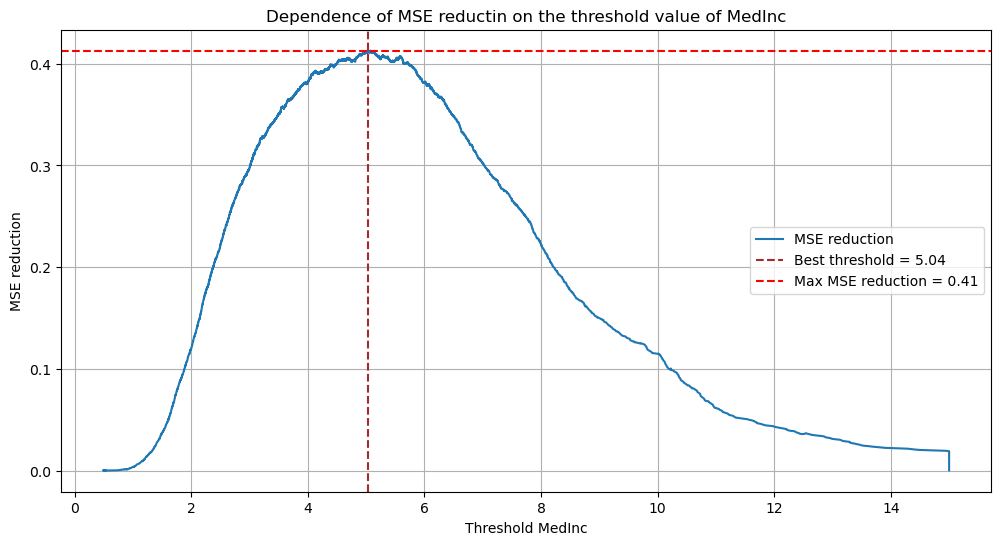

Best thгeshold: 5.0351
Max MSE reduction: 0.4128
Amount of threshold: 20639


In [437]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(thresholds, criteria, label='MSE reduction')
plt.axvline(x=best_threshold, linestyle='--', label=f'Best threshold = {round(best_threshold, 2)}', color='brown')
plt.axhline(y=best_criterion, linestyle='--', label=f'Max MSE reduction = {round(best_criterion, 2)}', color='red')

plt.xlabel('Threshold MedInc')
plt.ylabel('MSE reduction')
plt.title('Dependence of MSE reductin on the threshold value of MedInc')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best thгeshold: {best_threshold:.4f}")
print(f"Max MSE reduction: {best_criterion:.4f}")
print(f"Amount of threshold: {len(thresholds)}")

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [440]:
print(f'Список признаков датасета: {list(X.columns)}')
california_housing_features_description = {
    'MedInc': 'Median income for households within a block (scaled and capped)',
    'HouseAge': 'Median house age within a block',
    'AveRooms': 'Average number of rooms per household',
    'AveBedrms': 'Average number of bedrooms per household',
    'Population': 'Total population within a block',
    'AveOccup': 'Average household occupancy',
    'Latitude': 'Geographic latitude coordinate',
    'Longitude': 'Geographic longitude coordinate',
    'MedHouseVal': 'Median house value for households (target variable)'
}

Список признаков датасета: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


* Признаки AveRooms и Avebedrms думаю, что коррелируют со стоимостью дома, но как дорогие, так и недорогие имеют сопоставимое количество комнате. Часто различие в размере и инфрастуктуре комнат.
* HouseAge также коррелирует со стоимостью. Но новые крутые дома в престижном районе стоят сииильно дороже, чем новые дома в обычном районе.
* Latitude и Longtitude тоже может говорить о стоимости, например, район Беверли Хиллз имеют высокую стоимость домов, но граничащие дома из соседних районов могут иметь резко понижающуюся стоимость в сравнении с домами вышеупомянутого района.
* Обычно чем выше медианный доход в районе, тем выше медианная стоимость дома в районе. Ведь стоимость дома очень сильно коррелирует с доходом, ведь дом - это окружающая среда, в которой мы проводим кучу времени, и очевидно, что состоятельный люди в первую очередь покупают себе дорогой дом. Медианная стоимость дома в районе менее явно отражает стоимость дома, нежели медианная зп, так как в богатых районах есть обычные дома с комфортной жизнью, а есть куча трехэтажных домов с бассейнами и всякими ништяками.
Поэтому я считаю, что лучший признак - MedInc, ведь он явно коррелирует со стоимостью дома.

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [495]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = split = (sub_X[:, feature] <= threshold)
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = split = (sub_X[:, feature] == threshold)
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]
        
        feature_ind = node["feature_split"]
        feature_value = x[feature_ind]
        
        if self._feature_types[feature_ind] == "real":
            if np.isnan(feature_value): 
                return self._predict_node(x, node["left_child"])  
            if feature_value <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
                
        else:
            if np.isnan(feature_value):  
                return self._predict_node(x, node["left_child"])
            if feature_value == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

Задание 2.3 (1 балл) Загрузите таблицу students.csv (это немного преобразованный датасет User Knowledge). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

Dataset shape: (258, 6)
    STG   SCG   STR   LPR   PEG  UNS
0  0.00  0.00  0.00  0.00  0.00    0
1  0.08  0.08  0.10  0.24  0.90    1
2  0.06  0.06  0.05  0.25  0.33    0
3  0.10  0.10  0.15  0.65  0.30    1
4  0.08  0.08  0.08  0.98  0.24    0


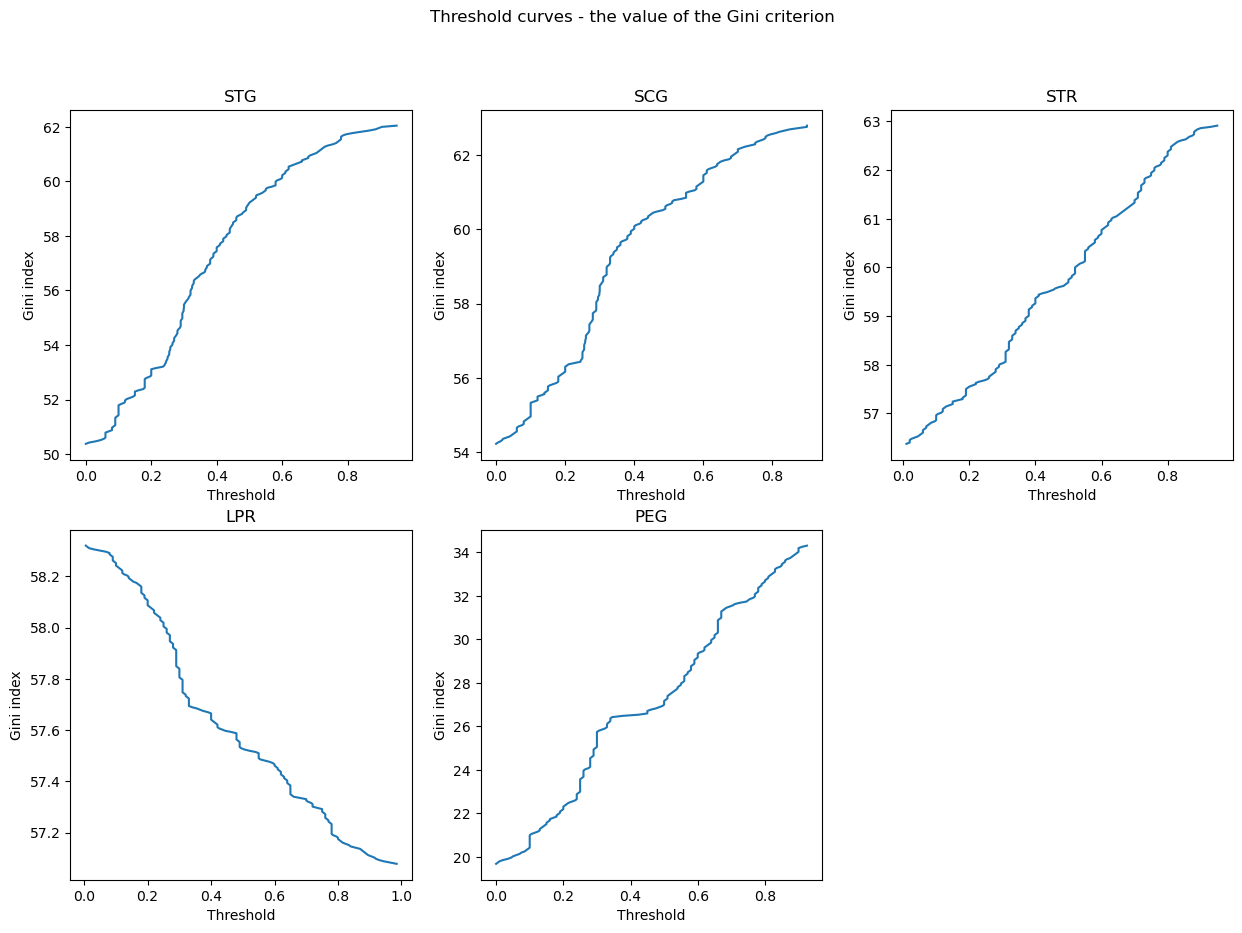

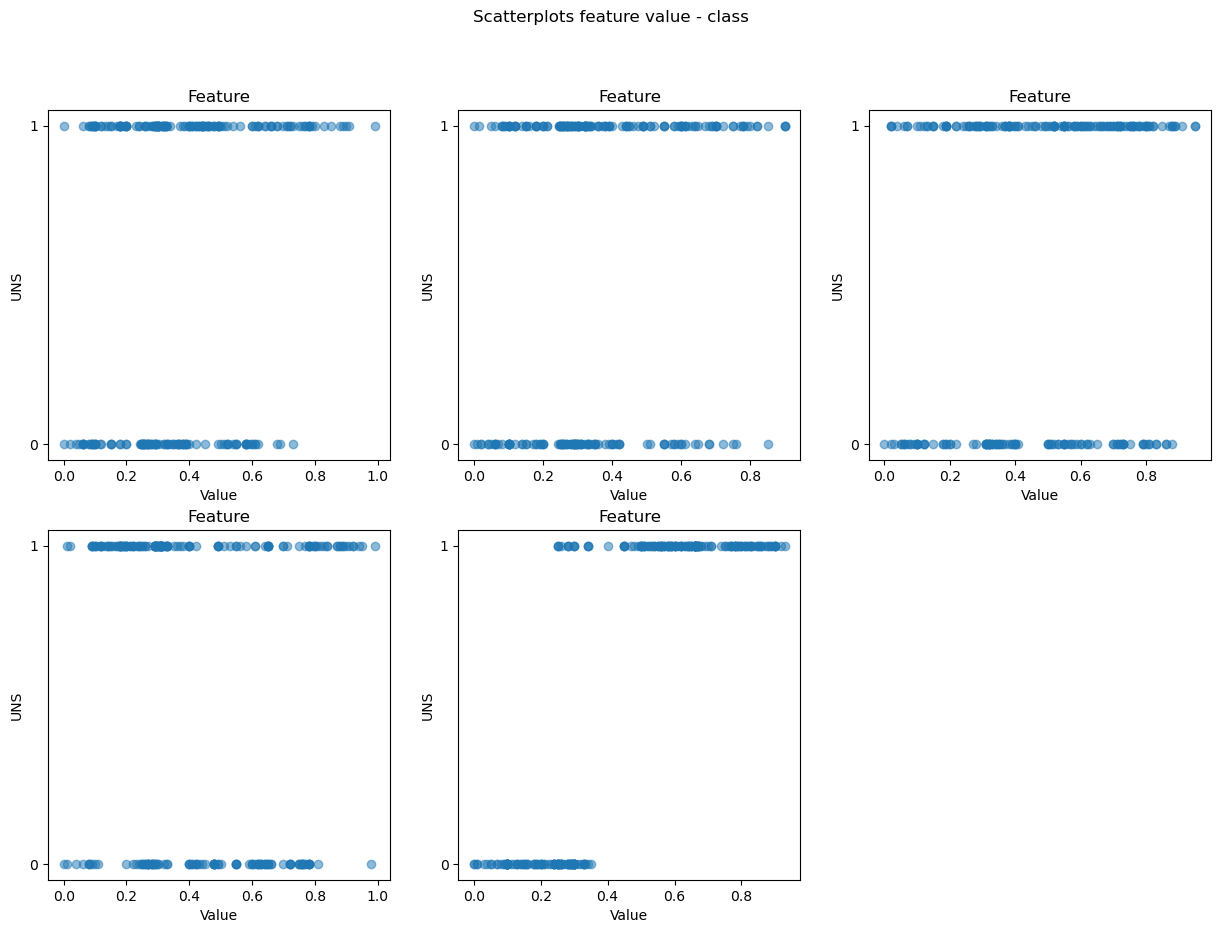

In [530]:
data = pd.read_csv("students.csv")
data = data.iloc[:, 1:7]
print(f"Dataset shape: {data.shape}")
print(data.head())
feature_names = data.columns[:5]
X = data.iloc[:, :-1] 
y = data.iloc[:, -1].values 


plt.figure(figsize=(15, 10))
for i, feature in enumerate(feature_names):
    plt.subplot(2, 3, i + 1)
    feature_vector = data[feature].values
    thresholds, ginis, best_threshold, best_gini = find_best_split(feature_vector, y)
    plt.plot(thresholds, ginis)
    plt.title(feature)
    plt.xlabel('Threshold')
    plt.ylabel('Gini index')

plt.suptitle('Threshold curves - the value of the Gini criterion')
plt.show()


plt.figure(figsize=(15, 10))
for i, feature in enumerate(feature_names):
    plt.subplot(2, 3, i + 1)
    plt.scatter(data[feature], y, alpha=0.5)
    plt.title('Feature')
    plt.xlabel('Value')
    plt.ylabel('UNS')
    plt.yticks([0, 1])

plt.suptitle('Scatterplots feature value - class')
plt.show()

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [503]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [505]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

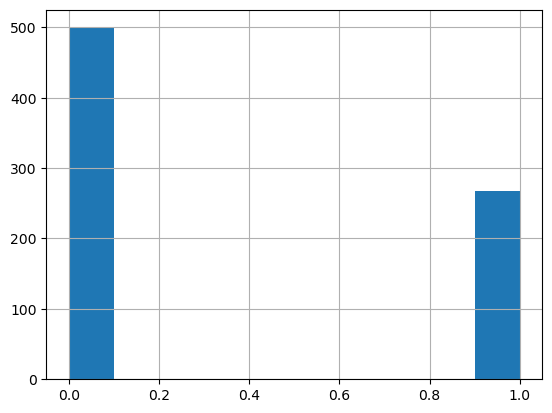

In [508]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [511]:
# Баланс классов.
zero_count = (data['Outcome'] == 0).sum()
one_count = (data['Outcome'] == 1).sum()

print(f"Количество нулей: {zero_count}")
print(f"Количество единиц: {one_count}")
print('Заметим, что количество нулей превосходит количество единиц чуть ли не в 2 раза, поэтому можем полагать, что классы несбалансированы.\n')

X = data.drop(["Outcome"], axis=1)
y = data["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train_train, X_train_valid, y_train_train, y_train_valid = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train)
print(f'Размер обучающей-обучающей: {round(len(X_train_train) / len(X), 2)}\nРазмер обучающей-тестовой: {round(len(X_train_valid) / len(X), 2)}\nРазмер тестовой: {round(len(X_test) / len(X), 2)}')

Количество нулей: 500
Количество единиц: 268
Заметим, что количество нулей превосходит количество единиц чуть ли не в 2 раза, поэтому можем полагать, что классы несбалансированы.

Размер обучающей-обучающей: 0.49
Размер обучающей-тестовой: 0.21
Размер тестовой: 0.3


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [514]:
max_depth_values = [None, 3, 5, 7, 9, 11, 13, 15]
min_samples_leaf_values = [1, 3, 5, 10, 15, 20, 0.01, 0.05, 0.1]

max_f1_score = 0
best_pair = [0, 0]
i = 0
for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        i += 1
        decision_tree_clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=52)
        decision_tree_clf.fit(X_train_train, y_train_train)

        valid_preds = decision_tree_clf.predict(X_train_valid)
        f1_score_valid = f1_score(y_train_valid, valid_preds)
        if i == 0 or f1_score_valid > max_f1_score:
            max_f1_score = f1_score_valid 
            best_pair = [max_depth, min_samples_leaf]

best_max_depth = best_pair[0]
best_min_samples_leaf = best_pair[1]
print(f'Лучшая Пара значений: max_depth={best_max_depth}, min_samples_leaf={best_min_samples_leaf} дает лучшее значение f1-score={round(max_f1_score, 3)}')        

Лучшая Пара значений: max_depth=5, min_samples_leaf=15 дает лучшее значение f1-score=0.667


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [517]:
bagging_clf = BaggingClassifier(n_estimators=50, max_samples=1.0, bootstrap=True)
bagging_clf.fit(X_train, y_train)
test_preds = bagging_clf.predict(X_test)
f1_score_test = f1_score(y_test, test_preds)
print(f'Качество на тестовой выборке BaggingClassifier: F1-score={round(f1_score_test, 2)}')

Качество на тестовой выборке BaggingClassifier: F1-score=0.67


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [520]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15, 0.01, 0.05],
    'n_estimators': [50]
}

rf = RandomForestClassifier(random_state=52)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
)
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'max_depth': None, 'min_samples_split': 0.05, 'n_estimators': 50}


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

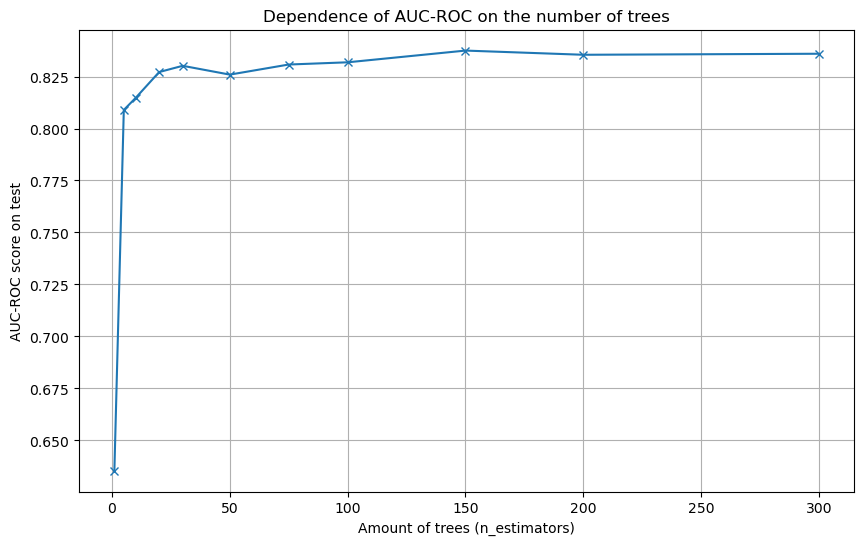

In [522]:
n_estimators_values = [1, 5, 10, 20, 30, 50, 75, 100, 150, 200, 300]
auc_scores = []

for n in n_estimators_values:
    model = RandomForestClassifier(n_estimators=n, random_state=52)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc)

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, auc_scores, marker='x')
plt.title('Dependence of AUC-ROC on the number of trees')
plt.xlabel('Amount of trees (n_estimators)')
plt.ylabel('AUC-ROC score on test')
plt.grid(True)
plt.show()

Можем увидеть, что при росте количества деревьев до 50 наблюдается стремительный рост AUC-ROC на тестовой выборке. 
Но при достижении 50-75 график выходит на плато, и качество снова начинает расти только при достижении 100. Далее график снова выходит на плато с малым ростом качества. Таким образом, лучшим количеством деревьев будет 30-50, так как это не будет трудозатратно на по времени и даст как можно хорошее качесто.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

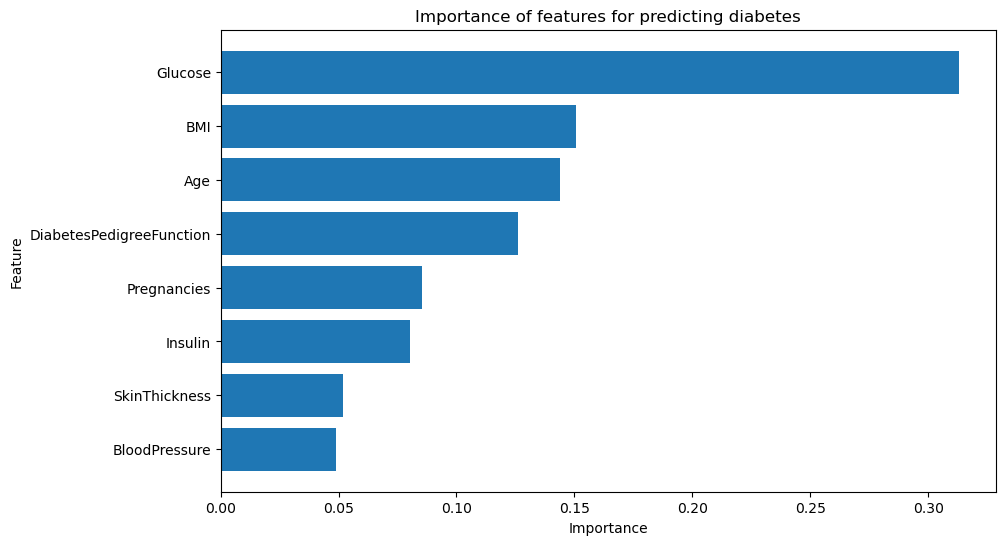

Most important feature: Glucose
Importance coefficient: 0.31


In [525]:
best_rf = grid_search.best_estimator_
feature_importances = best_rf.feature_importances_
features = X.columns

sorted_idx = np.argsort(feature_importances)
sorted_features = features[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.title('Importance of features for predicting diabetes')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

most_important_feature = features[np.argmax(feature_importances)]
print(f"Most important feature: {most_important_feature}")
print(f"Importance coefficient: {round(max(feature_importances), 2)}")

Самым главным признаком оказался признак - концентрация глюкозы через 2 часа при пероральном тесте на толерантность к глюкозе. Не особо шарю в этом, но думаю, что, если глюкоза ~ сахароза, то важный аспект при выявлении диабета.